# Tutorial on Feature Visualization

In this notebook we will 
- learn how to visualize concepts using Relevance and Activation Maximization
- compute conditional attributions on reference samples 
- compute the receptive field of neurons inside CNN layers and use it to crop out the most relevant part of the reference sample to increase interpretability even further
- cache and precompute reference images for optimal performance in low-latency applications

In [1]:
%matplotlib inline
# pip install zennit-crp

Let's start again by initializing the VGG16 model and the image of the lizard.

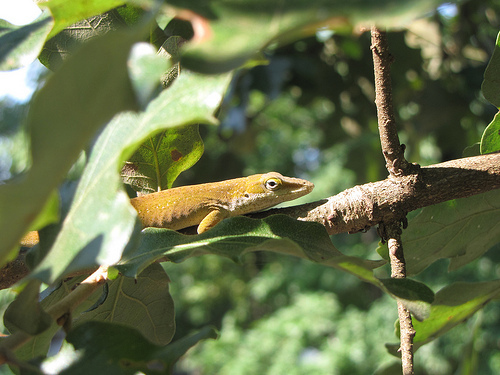

In [2]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

image = Image.open("VGG16_ImageNet/lizard.JPEG")

image

The `FeatureVisualization` class contains the functionality to visualize concepts. For this, we must first define what kind of concept is used in which layer of the model by initializing a _layer_map_ dictionary. Moreover, we need a dataset through which we iterate and a `CondAttribution` object that describes how attributions should be computed on the dataset. It is important not to apply any preprocessing to the images yet. This will be done later in the `FeatureVisualization` object, so that the built-in plot functions can be used. Otherwise you would have to write your own plot function.

In [3]:
import torch.nn
import torchvision
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from tutorials.VGG16_ImageNet.download_imagenet import download

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)

# seperate normalization from resizing for plotting purposes later
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

path = None #TODO fill or run download below

if path is None:
    path = "ImageNet_data"
    download(path)
    
# apply no normalization here!
imagenet_data = torchvision.datasets.ImageNet(path, transform=transform, split="val")  

Finally, we initialize the `FeatureVisualization` class with a custom preprocessing function.

In [24]:
fv_path = "VGG16_ImageNet"
fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path=fv_path)

That's it! Now run the analysis or skip it by going to the next line of Python code (the analysis results for layer features.40 were precomputed and are located inside the tutorials/VGG16_ImageNet directory).

In [5]:
# it will take approximately 30 min on a Titan RTX
saved_files = fv.run(composite, 0, len(imagenet_data), 32, 100)

In the previous notebook, we discovered the 5 most important concepts in classifying the lizard. Now let's visualize the 8 most representative input samples for each of these concepts using Relevance Maximization.

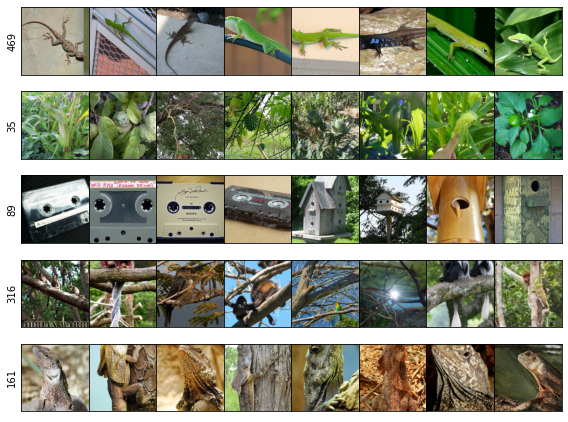

In [10]:
from crp.image import plot_grid

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8))

plot_grid(ref_c, figsize=(8, 6), padding=False)

The `plot_grid` function converts tensors of images and heatmaps to `PIL.Image` files automatically using the `zennit.imgify` function. Thus, you will find all necessary paramters of `zennit.imgify` also in `plot_grid`. In addition, `plot_grid` is capable of visualizing the types Dict[Any, List[Arrays]] as well as Dict[Any, Tuple[List[Arrays], List[Arrays]]]. 

### Conditonal Heatmaps on Reference Samples

The room for interpretation in the pictures is large. One does not know exactly which part to focus on. Therefore, we can compute conditional heatmaps for the concepts. The intern `attribution` method of the `CondAttribution` class starts the backward pass directly at the layer of the concept and initializes with the activation of the channel, so that we achieve a localization of the concept in input space. The method `get_max_reference` returns then the reference samples as well as attribution heatmaps as separate lists in the dictionary. More details on the `plot_fn` argument is coming soon.

To achieve this, we simply supply a zennit composite to the `composite` argument describing the rule used for computing attributions.

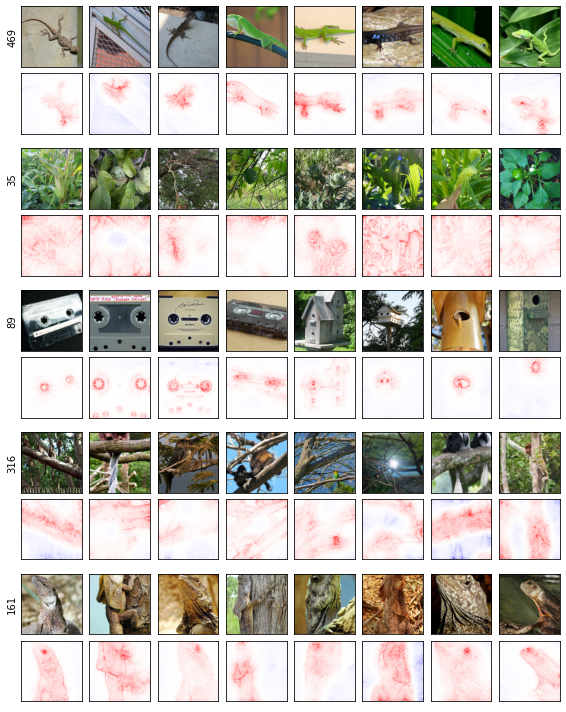

In [11]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), composite=composite, plot_fn=None)

plot_grid(ref_c, figsize=(8, 10))

The manner in which the reference images are plotted is controlled in the `plot_fn` argument of the `get_max_reference` method. If the parameter is None, the original tensors are returned. This function is given three arguments: unpreprocessed datasamples, the computed heatmap and a boolean `rf` (more about this in a moment). 
If you want to write your own plot function, you should follow this signature.
For example, to merge the heatmap into the reference image by utilizing it as an opaque mask to hide insignificant parts, we could use the prebuilt function `vis_opaque_img`.

However, by default, the `plot_fn` is set to `vis_img_heatmap`, which is simply applying `zennit.imgify` to all elements and cropping the receptive field (more about this in a moment).


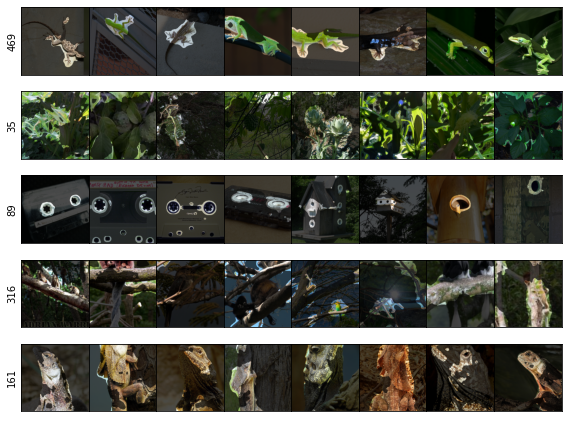

In [12]:
from crp.image import vis_opaque_img

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(8, 6))

### Zooming into the Receptive Field

2D-Conv layers are made up of an 2D-array of neurons with identical weights i.e. filters.
Instead of visualizing the whole input sample and its whole 2D-channel heatmap, we could focus on a single neuron, a single filter - the atomic unit - of a convolutional channel. By following the receptive field of the most relevant neuron inside a 2D-channel, we can zoom into the input sample and highlight the most important part of it. (The `FeatureVisualization` class automatically computes the most relevant neuron index during the analysis.)

For that, we must set the `rf` argument of the `get_max_reference` method to True and at the same time supply a zennit composite to the `composite` argument. Behind the scenes, the method computes an attribution starting at the most relevant neuron while initializing the relevance at all other neurons with zero. Inside the `plot_fn` the receptive field is then used to crop the image. (The cropping threshold and other hyperparameters of the `vis_opaque_img` or `vis_img_heatmap` function can be tuned wrt. your specific dataset.)

The `padding` argument specifies whether padding should be added to the reference images, just play around!

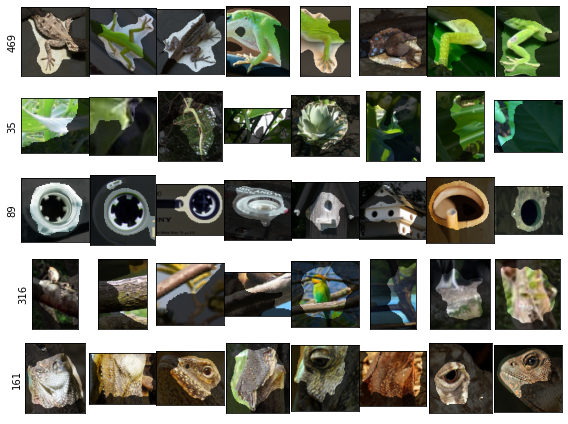

In [15]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), rf=True, composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_c, figsize=(8, 6), padding=False)

### Statistics

The library also calculates statistics about the average activation or relevance of a concept. This allows us to determine for which class this concept is most often used and which reference images in each class are most representative. This increases the diversity of the reference images, which is beneficial for interpretability.

The method `compute_stats` returns the most representative classes i.e. targets and their mean values. If you set the `norm` parameter, the values are normed wrt. the maximal value. Use the `top_N` parameter to return the top-N targets.

If you did not run the analysis on your own, you can only visualize the example below. Providing files for alle concepts and layers consumes too much disk space.

In [18]:
targets, rel = fv.compute_stats(469, "features.40", "relevance", top_N=5, norm=True)
targets, rel 

(array([46, 40, 42, 41, 44]), tensor([1.0000, 0.9527, 0.8887, 0.8757, 0.8646]))

Similar to `get_max_reference`, the method `get_stats_reference` returns PIL Images that can be plotted - depending on the `plot_fn` you supply.

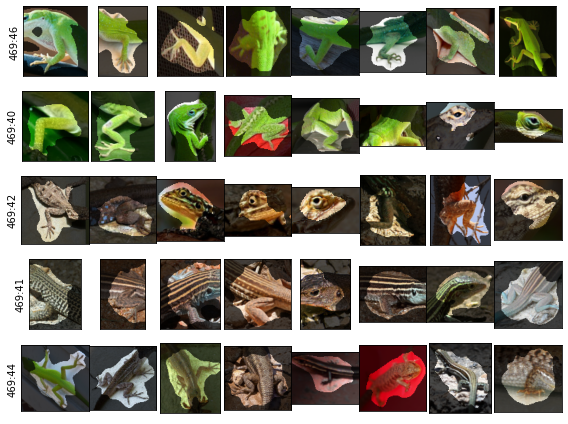

In [23]:
ref_t = fv.get_stats_reference(469, "features.40", targets, "relevance", (0, 8), rf=True, composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_t, figsize=(8, 6), padding=False)

Here we see, that for concept 469 the targets 46, 40, 42, 41 and 44 are most relevant. All classes show amphibian characteristics, thus channel 469 is specialized in detecting amphibian features - especially the legs of lizards.

### Caching and Precomputing Reference Images

The `ImageCache` provides the functionality to save and load single PIL Image files as they are found inside the _ref_ dictionary. For that, a path must be defined during instantiation and the object passed to the `FeatureVisualization` object inside the `cache` argument.
To construct a custom cache, you have to inherit the `Cache` class and only overwrite the `save` and `load` method. The `save` method is automatically called after visualizing the sample in the `plot_fn` function and thus saves its output values. On the other hand, the `load` method is called before computing the reference images and loads the files if available. This applies to both methods: `get_max_reference` and `get_stats_reference`.

Note, that `ImageCache` is able to save lists of PIL.Images as returned by `vis_opaque_img` and tuples of two lists of PIL.Images as returned by `vis_img_heatmap`.  

In [25]:
from crp.cache import ImageCache

cache = ImageCache(path="cache")

fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path=fv_path, cache=cache)

Let's measure the wall time for computing the reference images...

In [26]:
%%time 
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), rf=True, composite=composite)

CPU times: user 14.2 s, sys: 2.71 s, total: 16.9 s
Wall time: 1.35 s


... and then again after they were cached:

In [28]:
%%time 
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), rf=True, composite=composite)

CPU times: user 17.7 ms, sys: 4.32 ms, total: 22.1 ms
Wall time: 18.9 ms


Instead of calling `get_max_reference` for all concepts to fill the cache with images, we could precompute all reference images.

To do this, we call the `precompute_ref` method of the `FeatureVisualization` object and supply a dictionary that contains as keys layer names and as values the indices of concepts we'd like to compute. For convenience, we use the helper method `get_output_shapes` that traces the output of our model and returns the output shapes of our layers without batch dimensions as dictionary. Then, we use the dictionary to infer how many concepts we have in each layer.

The `plot_list` argument allows us to define several plot_fn with which we visualize the images and the `stats` argument computes reference images also for the `get_stats_reference` method, which will result in much larger disk space consumption. Depending on the selected parameters such as `composite` or `rf`, the images are saved separately in different folders. Just take a look into the cached files!

In [ ]:
from crp.helper import get_output_shapes
import numpy as np

layer_names = get_layer_names(model, [torch.nn.Conv2d])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_opaque_img], mode="relevance", r_range=(0, 16), composite=composite, rf=True, batch_size=32, stats=False)

Precomputing 32 reference images per concept for RelevanceMaximization in all convolutional layers of the VGG16 model consumes approximately 1.2 GB of disk space.